# Introduction

In this exercise, we want to extend on the abilites of the U-Net of the last exercise and create a Generative Adversarial Network. First we will apply it to a more complex segmentation task, while the U-Net is certainly suited to this task it can be improved by using GAN approaches for selfsupervision. Furthermore, the final GAN should be able to invert the task and recreate original images from the segmented images. Since the training of a GAN usually takes a while we will not achive realistic images but the structures and certain details should generate and be recognizable.

We will

1. Modify the Datapipe for a new Dataset

2. Extend the Model to create a GAN

3. Improving the Discriminator

4. Generate Images

For results the different Networks should be running and the Output of the Last Network (Section 4.) Should be submitted for after at least 20 Epochs. Any Question should be answered in as few sentences or bulletpoints as possible.

# 0. Prequisites

We will first import the necessary data. Please, before running the following code, access the link below, right click on the .zip file, then click "Add shortcut to Drive" and select your Drive folder:

https://drive.google.com/file/d/1BLMs1klSrIgZ48arCKYxpn0jTCrV3Hg6/view?usp=sharing

Like always:
Make sure to request GPUs from Colab.
Make a copy to allow saving.

In [57]:
#from google.colab import drive
# mount drive
#drive.mount('/content/drive')

#!unzip -qq '/content/drive/MyDrive/data/CMP_facade_DB.zip'

In [1]:
%cd content/CMP_facade_DB/

/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_06/content/CMP_facade_DB


This will handle all the imports we will need for this Notebook

In [2]:
import torch
import os
import random

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as TF

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models.mobilenetv2 import InvertedResidual

from utils.SegmentationModel import SegmentationModel

import matplotlib.pyplot as plt

# 1. Modify the Datapipe for a new Dataset

This time we are going to work with the segmentation of facades. A good first step is always to download the data and look into it. The folder structure should be the same as in the last exercise but some things will be different and we will need to modify the CustomDataset Class to make it work for our new Data.

1. The Masks have a different file type
2. The Images are neither of the same size nor do they have a constant aspect ratio
  - The images are a bit too detailed for the time we have for training so in a first step we want to half the size of the image
  -  We already have a random crop function we can use. But now not all images are at a minimum 256x256. So we have to change the function so that it will work with smaller inputs. Consider that the output size still needs to be 256x256! (Feel free to look up the code of the original *get_crop_param *function that we used)
3. We do not need nor want the same data augmentation.
  - In this usecase we will reduce most of the preprocessing and only apply the randomcrop and a horizontal flip.
  - Of course more preprocessing steps could be useful but some might not make sense with the data we were given. Why would we want or not want to apply: **Random rotation, Vertical flipping, Color Jitter, Gaussian Blur and Grayscale**?

*Optional: Resize the images by half or even to a quarter of the original size to make the training faster. (Recommended for testing and faster results)*




***Answer Questions here***

In [3]:
class CustomDataset(Dataset):
    def __init__(
        self, root_dir, transform, transform_mask):
        self.root_dir = root_dir
        self.transform = transform
        self.transform_mask = transform_mask

        self.img_dir = os.path.join(root_dir, "rgb")
        self.mask_dir = os.path.join(root_dir, "segmentation")
        self.img_filenames = sorted(os.listdir(self.img_dir))


    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        
        mask_filename = os.path.splitext(img_filename)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        image, mask = self.common_transform(image, mask)

        image = self.transform(image)
        mask = self.transform_mask(mask)

        return image, mask

    def get_crop_param(self, img, output_size):
        width, height = img.size
        if width < output_size or height < output_size:
            if width < height:
                new_width = output_size
                new_height = int(height * (output_size / width))
                return new_width, new_height
            else:
                new_width = int(width * (output_size / height))
                new_height = output_size
                return new_width, new_height
        return -1, -1


    def common_transform(self, image, mask):
        #print(image.size)
        resize_transform = transforms.Resize((image.size[1] // 2, image.size[0] // 2))
        image = resize_transform(image)
        mask = resize_transform(mask)
        # print(image.size)
        # Random crop
        new_width, new_height = self.get_crop_param(image, 256)

        if new_width != -1:
            resize_transform = transforms.Resize((new_width, new_height))
            image = resize_transform(image)
            mask = resize_transform(mask)
            #print(image.size)
        
        crop_size = 256
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #print(image.size)
        # # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        #Optional: More resizing

        return image, mask

In [4]:
# Define the paths to your train and test data folders
train_data_path = "train_data"
test_data_path = "test_data"

# Define the transformations to be applied to the images and masks
transform_img = transforms.Compose(
    [
        transforms.CenterCrop(256), #Optional: Change if you are resizing the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

transform_mask = transforms.Compose(
    [
        transforms.CenterCrop(256), #Optional: Change if you are resizing the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Create the training dataset
train_dataset = CustomDataset(
    root_dir=train_data_path,
    transform=transform_img,
    transform_mask=transform_mask
)

# Create the testing dataset
test_dataset = CustomDataset(
    root_dir=test_data_path,
    transform=transform_img,
    transform_mask=transform_mask
)

# Define the batch size for the DataLoader
batch_size = 16

# Create the testing data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This is a basic training loop that should work for the U-NET. Add the output function to check if your random crop and resize works and Run the U-NET with the new Data. The results should look like a "blobby" segmentations with mainly blue and red coloring. We do not need to train the network for long since a full training would take far too much time so we should not expect the results to be precice at this point.

In [5]:
import torchvision.utils as vutils

def plot_batch(batch_images, batch_masks):
    grid_images = vutils.make_grid(batch_images, nrow=4, padding=10, normalize=True)
    grid_masks = vutils.make_grid(batch_masks, nrow=4, padding=10, normalize=True)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].imshow(grid_images.permute(1, 2, 0))
    axes[0].set_title("Images")
    axes[0].axis("off")

    axes[1].imshow(grid_masks.permute(1, 2, 0))
    axes[1].set_title("Masks")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
output_interval = 3
learning_rate = 0.0002
num_epochs = 12

random.seed(42)
torch.manual_seed(42)

# Create an instance of the UNet
gen_model = SegmentationModel(3)

# Define loss functions
criterion = nn.L1Loss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)

# Move the model to the appropriate device (e.g., GPU if available)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:2')
gen_model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    total_l1 = 0.0
    num_samples = 0

    gen_model.train()  # Set the model to training mode

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)
        #plot_batch(img.cpu(), mask.cpu())
        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()
        # Forward pass
        output = gen_model(img)
        # Compute losses
        gen_loss = criterion(output, mask)
        loss = gen_loss

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss}")

    # Validation loop
    gen_model.eval()  # Set the model to evaluation mode
    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)
            val_loss += criterion(val_output, val_mask).item()

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_img.cpu(), val_output.cpu())

            iteration += 1

        # update validation loss
        val_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_loss}")

# 2. Extend the Model to create a GAN

GANs introduce a second Network, the discriminator to enable additional supervision in the trainings process. The discriminators' task is to decide if a given image is a real image or generated. it will be trained by its success on that task while the original Network will get feedback if and how easy this task was.

In our case the U-Net is the generator now we are missing the discriminator. At a first step we implement a simple discriminator Network. Four layers of both **Convolution** and **LeakyReLU** and a **Linear layer** outputting onto one Class. Add an **InstanceNorm2d** layer directly after the first Convolution layer.

In [11]:
class simpleDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(simpleDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 1024),
        )

        # The height and width of downsampled image
        ds_size = 256 // (2 ** 5)

        self.out_layer = nn.Sequential(
            nn.Linear(1024 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img_input):
        x = self.model(img_input)
        # Flattens the output to one per image in batch
        return self.out_layer(x.view(x.shape[0], -1))

We can adjust the training loop from the last exercise by adding the new losses and the new Network.
 1. The discriminator has to be included added to the trainings loop so it can be trained
 2. The gan_criterion has be be added to the Generator step.
 	- Since the losses are of different magnitude, weights have to be added. **Weight the existing l1Loss 100 times the gan Loss**
 3. Add the training for the Discriminator in the Discriminator step

 Run the GAN now. The Network should quickly manage to color the image mainly in blue background and add some light blue, red, and green segmentation to many objects in the Image. Again we do not need to train the network for long time just for a few outputs to be created.

Epoch 1/12: 100%|████████████████████| 19/19 [00:12<00:00,  1.51it/s, Loss=1.54]


Epoch 1/12 | Training Loss: 1.5263280805788542
Epoch 1/12 | Validation Loss: 0.8516629457473754


Epoch 2/12: 100%|████████████████████| 19/19 [00:16<00:00,  1.17it/s, Loss=1.51]


Epoch 2/12 | Training Loss: 1.5210918250836825
Epoch 2/12 | Validation Loss: 0.8280317664146424


Epoch 3/12: 100%|████████████████████| 19/19 [00:12<00:00,  1.54it/s, Loss=1.45]


Epoch 3/12 | Training Loss: 1.4879151770943089


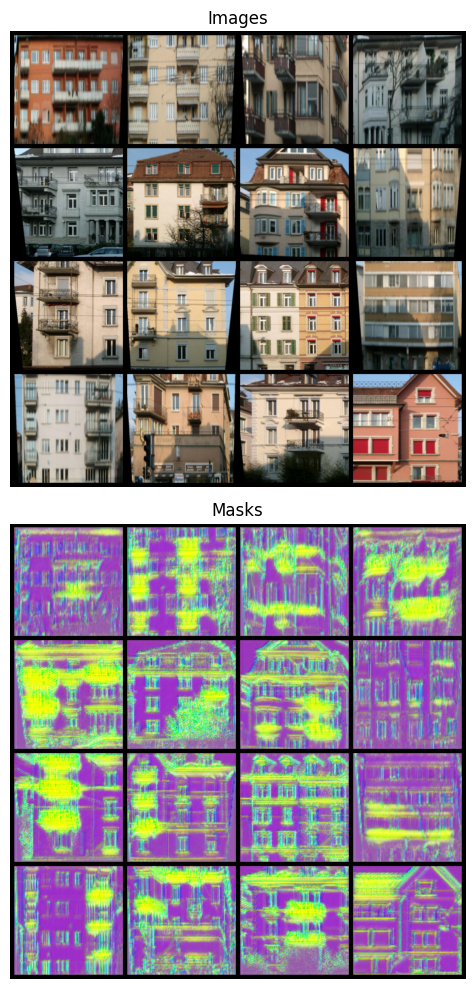

Epoch 3/12 | Validation Loss: 0.8137440919876099


Epoch 4/12: 100%|████████████████████| 19/19 [00:17<00:00,  1.06it/s, Loss=1.41]


Epoch 4/12 | Training Loss: 1.4397259009511847
Epoch 4/12 | Validation Loss: 0.7331220269203186


Epoch 5/12: 100%|████████████████████| 19/19 [00:09<00:00,  2.06it/s, Loss=1.36]


Epoch 5/12 | Training Loss: 1.3917042581658614
Epoch 5/12 | Validation Loss: 0.6991974472999573


Epoch 6/12: 100%|████████████████████| 19/19 [00:12<00:00,  1.58it/s, Loss=1.35]


Epoch 6/12 | Training Loss: 1.3593417845274274


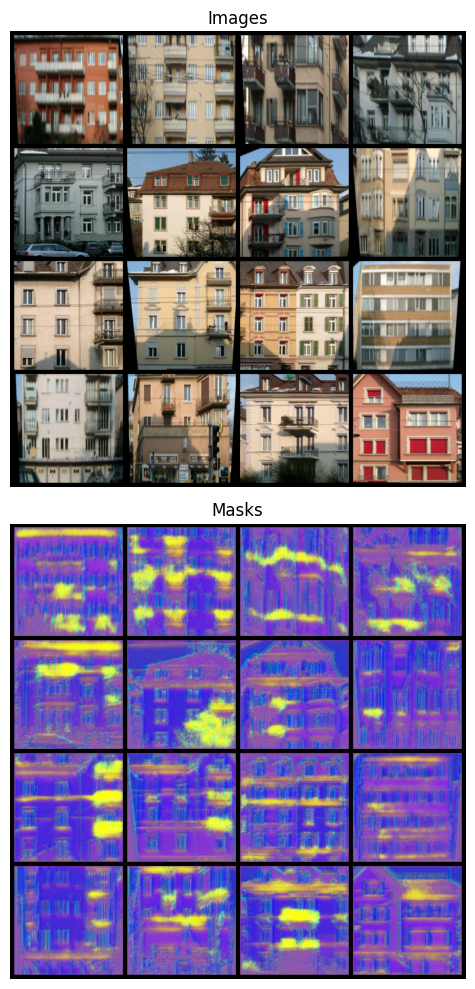

Epoch 6/12 | Validation Loss: 0.6601194977760315


Epoch 7/12: 100%|████████████████████| 19/19 [00:15<00:00,  1.24it/s, Loss=1.31]


Epoch 7/12 | Training Loss: 1.3318786934802407
Epoch 7/12 | Validation Loss: 0.6295282721519471


Epoch 8/12: 100%|████████████████████| 19/19 [00:08<00:00,  2.26it/s, Loss=1.29]


Epoch 8/12 | Training Loss: 1.3145807354073775
Epoch 8/12 | Validation Loss: 0.6168459296226502


Epoch 9/12: 100%|████████████████████| 19/19 [00:14<00:00,  1.31it/s, Loss=1.26]


Epoch 9/12 | Training Loss: 1.2898043017638356


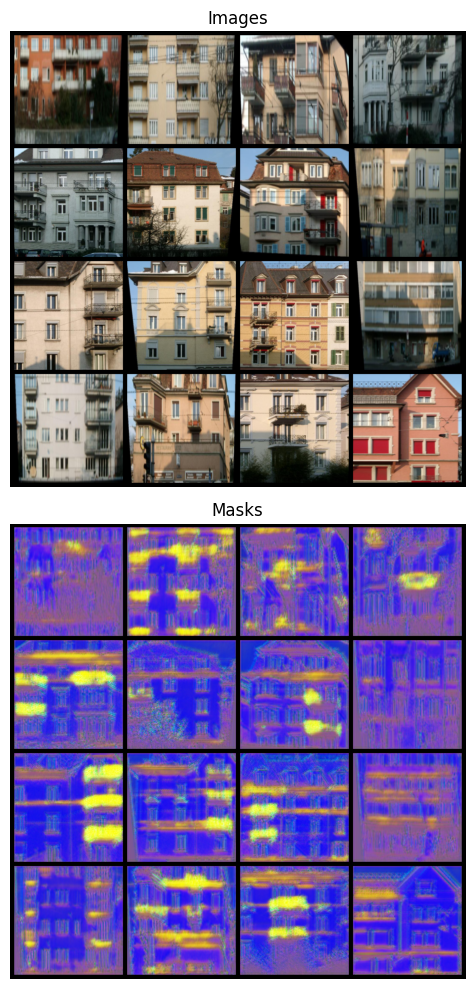

Epoch 9/12 | Validation Loss: 0.6033697247505188


Epoch 10/12: 100%|███████████████████| 19/19 [00:08<00:00,  2.28it/s, Loss=1.28]


Epoch 10/12 | Training Loss: 1.2689416847730939
Epoch 10/12 | Validation Loss: 0.5892965912818908


Epoch 11/12: 100%|███████████████████| 19/19 [00:15<00:00,  1.20it/s, Loss=1.25]


Epoch 11/12 | Training Loss: 1.249723798350284
Epoch 11/12 | Validation Loss: 0.6085813283920288


Epoch 12/12: 100%|███████████████████| 19/19 [00:08<00:00,  2.23it/s, Loss=1.21]


Epoch 12/12 | Training Loss: 1.2249606596796137


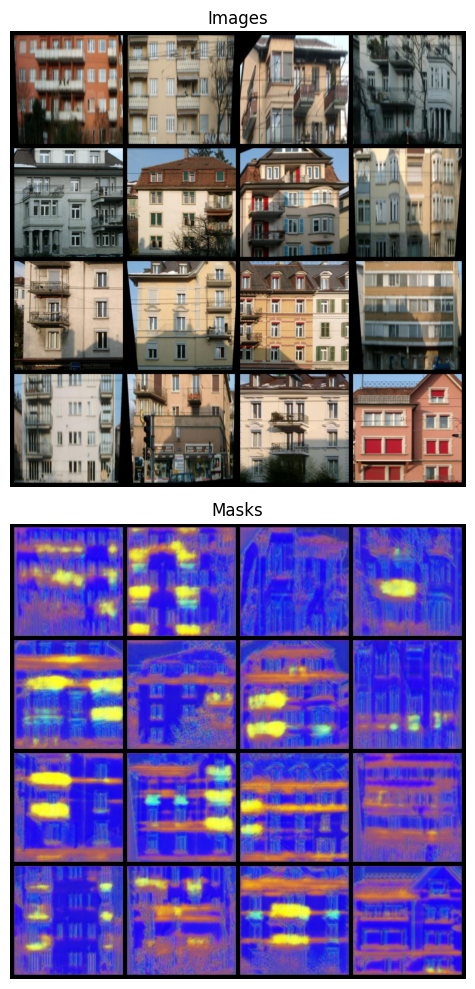

Epoch 12/12 | Validation Loss: 0.5651280999183654


In [14]:
output_interval = 3
learning_rate = 0.0002
num_epochs = 12

random.seed(42)
torch.manual_seed(42)

# Create an instance of the Networks
gen_model = SegmentationModel(3)
dis_model = simpleDiscriminator(3)

# Define loss functions
criterion = nn.L1Loss()
gan_criterion = nn.BCEWithLogitsLoss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)
dis_optimizer = optim.Adam(dis_model.parameters(), lr=learning_rate)

# Move the models to the appropriate device (e.g., GPU if available)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:3')

gen_model.to(device)
dis_model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    total_l1 = 0.0
    num_samples = 0

    # Set the models to training mode
    gen_model.train()
    dis_model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)

        # Define ground truths for the GAN
        valid = torch.ones((img.shape[0], 1), dtype=img.dtype, device=img.device, requires_grad=False)
        fake = torch.zeros((img.shape[0], 1), dtype=img.dtype, device=img.device, requires_grad=False)

        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()
        # Forward pass
        output = gen_model(img)
        # Compute losses
        gen_loss = criterion(output, mask)
        gan_loss = gan_criterion(dis_model(output), valid)
        loss = gen_loss + gan_loss

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        train_loss += loss.item()

        #### ------------------ ####
        #    Discriminator step    #
        #### ------------------ ####

        # Set discriminator gradients to zero
        dis_optimizer.zero_grad()
        # Forward pass with real samples
        real_loss = gan_criterion(dis_model(mask), valid)
        # Forward pass with fake samples
        fake_loss = gan_criterion(dis_model(output.detach()), fake)
        # Compute discriminator loss as the sum of real and fake losses
        dis_loss = real_loss + fake_loss

        # Backward pass and optimization step
        dis_loss.backward()
        dis_optimizer.step()

    train_loss /= len(train_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss}")

    # Validation loop
    gen_model.eval()  # Set the generator model to evaluation mode
    dis_model.eval()  # Set the discriminator model to evaluation mode
    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)
            val_loss += criterion(val_output, val_mask).item()

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_img.cpu(), val_output.cpu())

            iteration += 1

        # update validation loss
        val_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_loss}")


#3. Improving the Discriminator

So far the Discriminator is only looking at the image as a whole. A common approach to improve this is to use PatchGAN. For a transformation of an image A to B, in our case Image to Segmentation Mask, it will do two things:

1. It will look at patches instead of the whole image. For this task we create another Discriminator, which instead of the last conv and linear layer has a **ZeroPad2d** and a **Conv2d** Layer. Removing the last Conv-Layer will result in a 32x32 image, the padding layer should pad zeroes on the left and the top. The last Conv layer should result in 30x30 matrix where each value represents the result of a patch.  

2. it will use two images as input and will compare Image A to target B and Image A to generated A, the generator's task is to reduce the difference between those two comparisons while the discriminator's task is to increase the difference between them.

*Hint: Despite these changes the code of the discriminator does not need to change a lot.*

Furthermore we change the Crossentropy criterion to nn.MSELoss(). Why is that?




***Answer Questions here***



In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 1024),
            nn.ZeroPad2d(1),
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
### patchgan TODO: Improve the Ground Truth (valid and fake) and pass two images to the discriminator. Also we want to improve the Validation outputs
#HINT: Do not forget to add your changes from the simple GAN!

output_interval = 3
learning_rate = 0.0002
num_epochs = 18

random.seed(42)
torch.manual_seed(42)

# Create an instance of the UNet
gen_model = SegmentationModel(3)

# get output shape of image discriminator (PatchGAN)
patch = (256 // 2 ** 4, 256 // 2 ** 4) #Optional: If you changed the size of the input image you will need to change the values here

# Define loss functions
criterion = nn.L1Loss()
gan_criterion = nn.MSELoss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model.to(device)

# Training loop
for epoch in range(num_epochs):
    gen_train_loss = 0.0
    dis_train_loss = 0.0
    gen_val_loss = 0.0
    dis_val_loss = 0.0
    num_samples = 0

    # Set the models to training mode
    gen_model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)

        # Define ground truths for the GAN
        # Hint: you will need the patch variable
        valid = #...
        fake = #...

        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()
        # Forward pass
        output = gen_model(img)
        # Compute losses
        gen_loss = criterion(output, mask)
        #...

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        train_loss += loss.item()

        #### ------------------ ####
        #    Discriminator step    #
        #### ------------------ ####

        #...

    gen_train_loss /= len(train_loader)
    dis_train_loss /= len(train_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Generator Training Loss: {gen_train_loss} | Discriminator Training Loss: {dis_train_loss}")

    # Validation loop
    # Set the models to evaluation mode
    gen_model.eval()


    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)

            # Define ground truths for the GAN
            valid = #...
            fake = #...

            # compute validation loss
            gen_val_loss += criterion(val_output, val_mask).item()
            #...

            # compute discriminator validation loss
            #...

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_img.cpu(), val_output.cpu())

            iteration += 1

        # update validation loss
        gen_val_loss /= len(test_loader)
        dis_val_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {gen_val_loss} | Discriminator Validation Loss: {dis_val_loss}")

# 4. Generate Images

The Network we recreated so far is the Pix2Pix Network. While it is suitable for different tasks the original paper is famous for generating facades from  segmentation images. So as a last step we flip out inputs around.

 - You will have to modify the dataloader to change target and input. P*lease make it in a way that a flag can be set to activate the flip*
 - The training loop should be the same as it will work in both directions!

Unfortunatly, the results presented in the paper should, in our case, generate after roughly 600 epochs. But we should already see structures that look like facades after 24 epochs.

By Looking at the generated images and the source data, it is obvious that some parts of the original images are not generated at all. What could be the reason for it?

***Answer Questions here***